In [1]:
# Descomentar para actualizar librerias
# Si se actualiza alguna libreria hay que reiniciar el notebook
# !pip install pandas --upgrade --user --quiet
# !pip install numpy --upgrade --user --quiet
# !pip install scipy --upgrade --user --quiet
# !pip install statsmodels --upgrade --user --quiet
# !pip install scikit-learn --upgrade --user --quiet
!pip install missingno --upgrade --user --quiet
!pip install apafib --upgrade --user --quiet

  Preparing metadata (setup.py) ... done


In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# ¿Que edad tienes?
*Ejercicio individual - Anton Hurtado*

En este ejercicio vamos a intentar predecir la edad de una persona a partir del dataset Stroke Prediction Dataset.

# Apartado A
En el primer apartado del ejercicio vamos a hacer una exploración mínima sobre los datos stroke, para ver sus diferentes relaciones. Vamos a partir del dataset en el conjunto de entrenamiento y de test, stroke_train y stroke_test, respectivamente. Luego haremos un preprocesado en el conjunto de entrenamiento: transformar las variables, corregiremos los valores perdidos, los valores extremos, generalizar y normalizar. Y hacer lo mismo para el conjunto de test.

## Carga de los datos y Visualización básica

In [3]:
from apafib import load_stroke
stroke_data = load_stroke()

stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1,33879,Male,42.0,0,0,Yes,Private,Rural,83.41,25.4,Unknown,1
2,14248,Male,48.0,0,0,No,Govt_job,Urban,84.20,29.7,never smoked,1
3,62602,Female,49.0,0,0,Yes,Private,Urban,60.91,29.9,never smoked,1
4,36338,Female,39.0,1,0,Yes,Private,Rural,58.09,39.2,smokes,1


Cargamos el conjunto de datos y observamos que hay tanto datos numéricos *(avg_glucose_level, bmi, ...)* como datos categóricos *(gender, ever_married, ...)*.

De la página del dataset [kaggle.com/datasets/fedesoriano/stroke-prediction-dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) podemos ver sus respectivos atributos:

1. id: identificador único
2. gender: "Male", "Female" u "Other"
3. age: edad del paciente
4. hypertension: 0 si el paciente no tiene hipertensión, 1 si el paciente tiene hipertensión
5. heart_disease: 0 si el paciente no tiene ninguna cardiopatía, 1 si el paciente tiene una cardiopatía
6. ever_married: "No" o "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" o "Self-employed"
8. Residence_type: "Rural" o "Urban"
9. avg_glucose_level:  nivel medio de glucosa en sangre
10. bmi: índice de masa corporal
11. smoking_status: "formerly smoked", "never smoked", "smokes" o "Unknown". "Unknown" significa que la información no está disponible para este paciente
12. stroke: 1 si el paciente sufrió un ictus o 0 en caso contrario

In [4]:
stroke_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,2818.0,NaN,NaN,NaN,36927.369,20893.521,77.0,18716.5,37200.5,54905.75,72940.0
gender,2818,2,Female,1682,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,2818.0,NaN,NaN,NaN,26.817,14.429,0.08,15.0,28.0,39.75,49.0
hypertension,2818.0,NaN,NaN,NaN,0.027,0.162,0.0,0.0,0.0,0.0,1.0
heart_disease,2818.0,NaN,NaN,NaN,0.004,0.065,0.0,0.0,0.0,0.0,1.0
ever_married,2818,2,No,1542,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,2818,5,Private,1634,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,2818,2,Urban,1414,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,2818.0,NaN,NaN,NaN,96.371,32.064,55.12,75.675,89.195,108.08,267.76
bmi,2818.0,NaN,NaN,NaN,27.589,8.432,10.3,21.5,26.2,32.1,97.6


Como tarea objetivo tenemos predecir la edad de las personas. Reordenamos así las columnas de manera que la variable respuesta sea la primera.

In [5]:
cols = list(stroke_data.columns)
cols.remove('age')
cols.insert(0, 'age')
stroke_data = stroke_data.reindex(columns=cols)
stroke_data.head()

,age,id,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,49.0,60182,Female,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1,42.0,33879,Male,0,0,Yes,Private,Rural,83.41,25.4,Unknown,1
2,48.0,14248,Male,0,0,No,Govt_job,Urban,84.20,29.7,never smoked,1
3,49.0,62602,Female,0,0,Yes,Private,Urban,60.91,29.9,never smoked,1
4,39.0,36338,Female,1,0,Yes,Private,Rural,58.09,39.2,smokes,1


Vamos a eliminar la variable identificador *id*, ya que no servirá para la tarea.

In [6]:
stroke_data.drop(columns=['id'], inplace=True)
stroke_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,2818.0,NaN,NaN,NaN,26.817,14.429,0.08,15.0,28.0,39.75,49.0
gender,2818,2,Female,1682,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hypertension,2818.0,NaN,NaN,NaN,0.027,0.162,0.0,0.0,0.0,0.0,1.0
heart_disease,2818.0,NaN,NaN,NaN,0.004,0.065,0.0,0.0,0.0,0.0,1.0
ever_married,2818,2,No,1542,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,2818,5,Private,1634,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,2818,2,Urban,1414,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,2818.0,NaN,NaN,NaN,96.371,32.064,55.12,75.675,89.195,108.08,267.76
bmi,2818.0,NaN,NaN,NaN,27.589,8.432,10.3,21.5,26.2,32.1,97.6
smoking_status,2818,4,Unknown,1107,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Partición del conjunto de datos

Partiremos el conjunto de datos *stroke_data* en datos de entrenamiento y test, con un tamaño del 70% para el *stroke_train* y un 30% para *stroke_train*.

Los datos de test **no los tocaremos hasta el final** y les aplicaremos el preprocesado calculado con el conjunto de entrenamiento.

In [7]:
from sklearn.model_selection import train_test_split

stroke_train, stroke_test = train_test_split(stroke_data, test_size=0.3, random_state=0)

stroke_train.shape, stroke_test.shape

((1972, 11), (846, 11))

## Preproceso del conjunto de entrenamiento

### Variables numéricas
Procedemos a visualizar las variables numéricas.

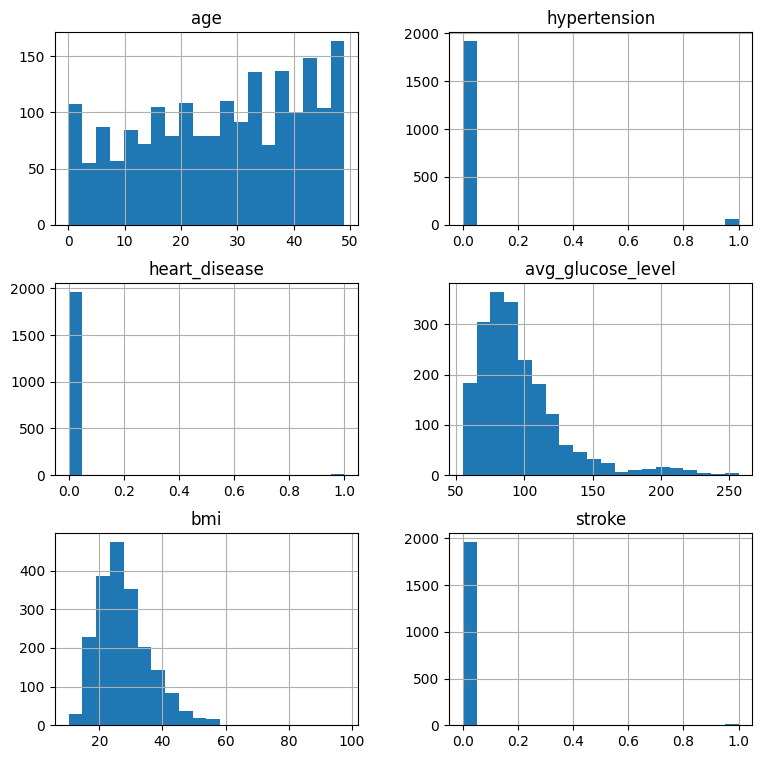

In [8]:
stroke_train.loc[:,['age','hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']].hist(bins=20, figsize=(9,9));

#### bmi, avg_glucose_level

Comprobamos si *bmi* y *avg_glucose_level* siguen una distribución normal.

In [9]:
from scipy.stats import normaltest

print(normaltest(stroke_train['avg_glucose_level'], nan_policy='omit'))
print(normaltest(stroke_train['bmi'], nan_policy='omit'))

NormaltestResult(statistic=743.942813154428, pvalue=2.8501695616353273e-162)
NormaltestResult(statistic=550.5137433870757, pvalue=2.867210098150496e-120)


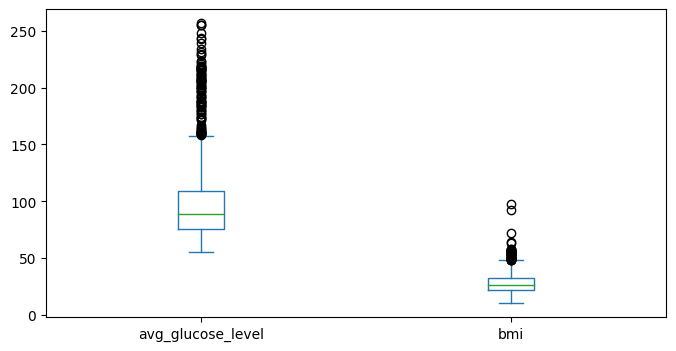

In [10]:
stroke_train.loc[:,['avg_glucose_level', 'bmi']].plot.box(figsize=(8,4));

Podemos observar que las variables *avg_glucose_level* y *bmi* presentan algunos outliers. Por ahora vamos a dejar estos valores.

#### hypertension, heart_disease, stroke

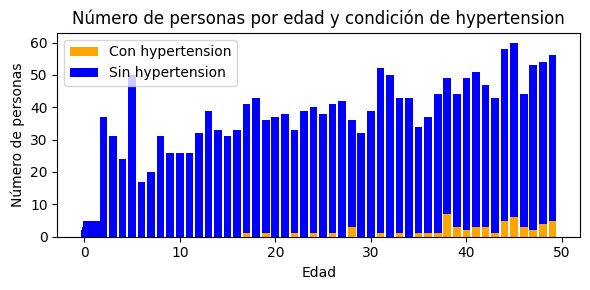

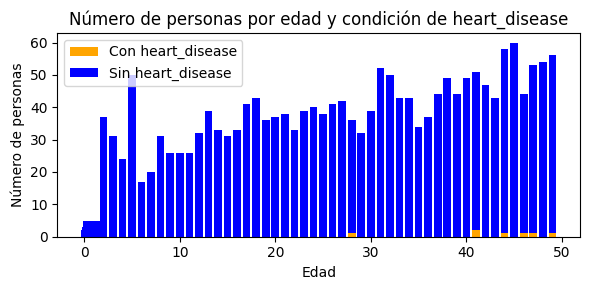

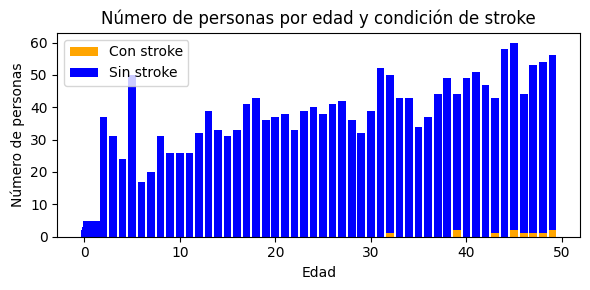

In [11]:
# stroke_train.hist(column='age',by='hypertension',bins=10, sharey=True, figsize=(10,6), layout=(1,2));

import matplotlib.pyplot as plt

def plot_condition_data(condition):
    # Agrupa los datos según la condición actual
    grouped_data = stroke_train.groupby(['age', condition]).size().unstack(fill_value=0)

    # Crea la gráfica
    plt.figure(figsize=(6,3))
    plt.bar(grouped_data.index, grouped_data[1], color='orange', label=f'Con {condition}')
    plt.bar(grouped_data.index, grouped_data[0], color='blue', bottom=grouped_data[1], label=f'Sin {condition}')
    plt.title(f'Número de personas por edad y condición de {condition}')
    plt.xlabel('Edad')
    plt.ylabel('Número de personas')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Lista de condiciones
conditions = ['hypertension', 'heart_disease', 'stroke']

# Itera sobre cada condición y llama a la función
for condition in conditions:
    plot_condition_data(condition)


En estas gráficas podemos ver como las variables *heart_disease y stroke* tienen unas proporciones ínfimas, no apartan ninguna utilidad a la hora de predecir la variable objetivo *age*. La variable *hypertension* puede tener más sentido porque va aumentando a medida que avanza la edad y tienen más representación que las otras dos.

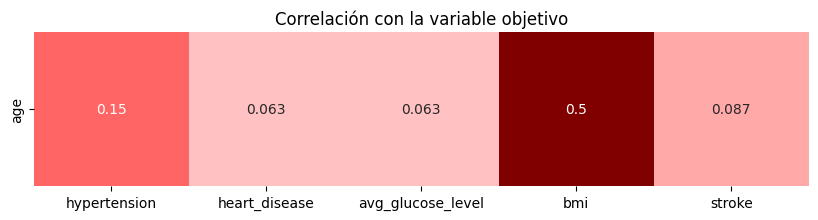

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calcula la matriz de correlación
corr = stroke_train.corr(numeric_only=True)

# Selecciona la fila de correlaciones de la variable objetivo
corr_target = corr.iloc[0].to_frame().T.drop(corr.columns[0], axis=1)  # asume que la primera fila es la variable objetivo

# Crea el heatmap sin la barra de colores
plt.subplots(figsize=(10, 2))  # Ajusta el tamaño para que sea más horizontal
sns.heatmap(corr_target, cmap='seismic', center=0, annot=True, cbar=False)  # cbar=False para ocultar la barra de colores
plt.title("Correlación con la variable objetivo")
plt.show();


Con el heatmap también se puede apreciar la correlación infima de *heart_disease y stroke* , mientras que *hypertension* tiene mayor correlación.
Es por ello que se va a procede a eliminar *heart_disease y stroke*, ya que no aportan practicamente ninguna información a la variable objetivo *age*:

In [13]:
stroke_train.drop(columns=['heart_disease', 'stroke'], inplace=True)
stroke_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1972.0,NaN,NaN,NaN,27.147,14.428,0.08,15.75,28.0,40.0,49.0
gender,1972,2,Female,1178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hypertension,1972.0,NaN,NaN,NaN,0.029,0.168,0.0,0.0,0.0,0.0,1.0
ever_married,1972,2,No,1073,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,1972,5,Private,1149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,1972,2,Rural,989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,1972.0,NaN,NaN,NaN,96.407,31.748,55.12,75.612,89.175,108.72,256.74
bmi,1972.0,NaN,NaN,NaN,27.855,8.605,10.3,21.8,26.4,32.3,97.6
smoking_status,1972,4,Unknown,771,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Variables categóricas
Procedemos a visualizar las variables categóricas para realizar su transformación recodificándolas a variables numéricas.

#### gender

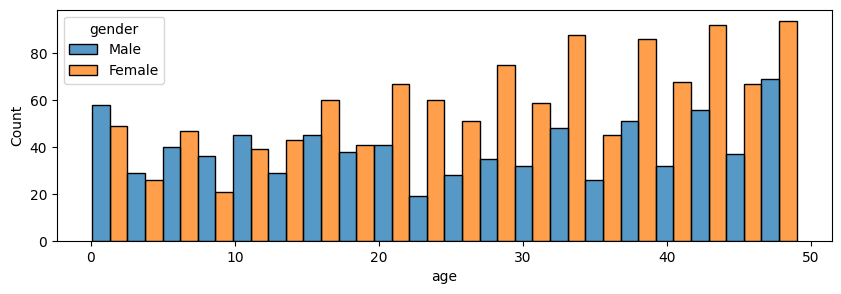

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
sns.histplot(data=stroke_train, x='age', hue='gender', multiple='dodge', bins=20, edgecolor='black')
plt.show();

Podemos observar que el número de mujeres es mayor que el de hombres en la franja de más edad. Vamos a transformarla en una variable binaria siendo 0 hombre y 1 mujer.

In [15]:
stroke_train['gender'].replace(['Male','Female'], [0,1], inplace=True)

#### ever_married

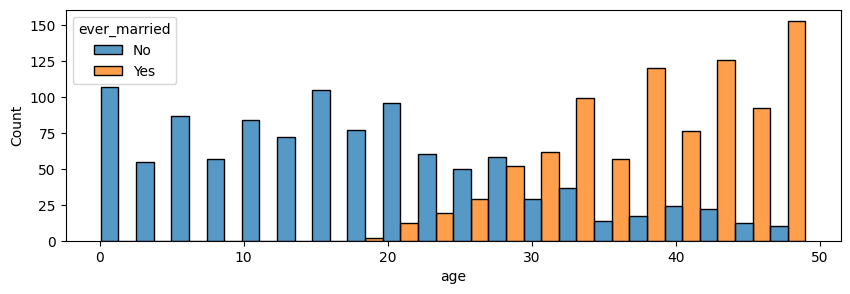

In [16]:
plt.figure(figsize=(10, 3))
sns.histplot(data=stroke_train, x='age', hue='ever_married', multiple='dodge', bins=20, edgecolor='black')
plt.show();

Como es lógico, a medida que avanza la edad más gente está casada. También la convertiremos en una variable binaria, siendo 0 que nunca se ha casado y 1 que sí.

In [17]:
stroke_train['ever_married'].replace(['No','Yes'], [0,1], inplace=True)

#### Residence_type

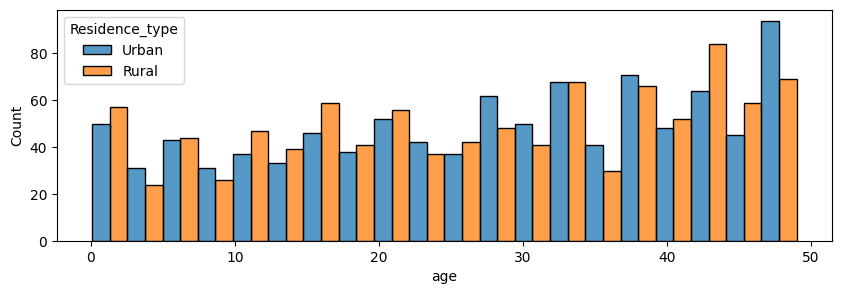

In [18]:
plt.figure(figsize=(10, 3))
sns.histplot(data=stroke_train, x='age', hue='Residence_type', multiple='dodge', bins=20, edgecolor='black')
plt.show();

Vemos una distribución bastante homogénea de los datos de tipo de residencia.

También la convertiremos en una variable binaria, siendo 0 que vive en una área urbana y 1 en una are rural.

In [19]:
stroke_train['Residence_type'].replace(['Urban', 'Rural'], [0,1], inplace=True)

#### work_type

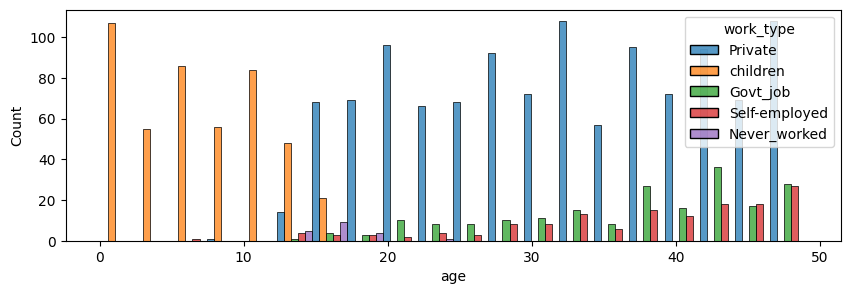

In [20]:
plt.figure(figsize=(10, 3))
sns.histplot(data=stroke_train, x='age', hue='work_type', multiple='dodge', bins=20, edgecolor='black')
plt.show();

Como es lógico, la gente menor de edad no trabaja, y vemos como la gran mayoría de gente trabaja en el sector privado, y como a medida que avanza la edad también aumente el número de personas que son autónomas o trabajan en el sector público.

Como la variable work_type tiene 5 valores posibles y no tienen un orden específico entre ellos, vamos a mantener la independencia del orden con la recodificación **One-Hot encoding**: generamos una variable binaria para cada una de ellas donde tenemos un valor 1 en la variable que corresponde al valor que tiene el ejemplo y 0 en el resto, posteriormente eliminamos una de las columnas, ya que una siempre es una combinación lineal de las otras y algunos modelos no admiten que eso suceda en la matriz de datos.

In [21]:
# Generamos c-1 variables, las añadimos al dataframe y eliminamos la variable
dummies = pd.get_dummies(stroke_train['work_type'], drop_first=True, prefix='work_type', prefix_sep='_')
stroke_train = pd.concat([stroke_train,dummies], axis=1)
stroke_train.drop(columns=['work_type'], inplace=True)
stroke_train.head()

,age,gender,hypertension,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
206,29.0,0,0,0,0,207.58,22.8,smokes,0,1,0,0
2037,2.0,1,0,0,0,105.75,19.8,Unknown,0,0,0,1
1824,42.0,1,0,1,1,80.00,27.5,never smoked,0,1,0,0
2029,39.0,1,0,1,0,78.24,28.6,Unknown,0,1,0,0
2441,42.0,0,0,1,1,67.97,23.8,Unknown,0,0,0,0


#### smoking_status

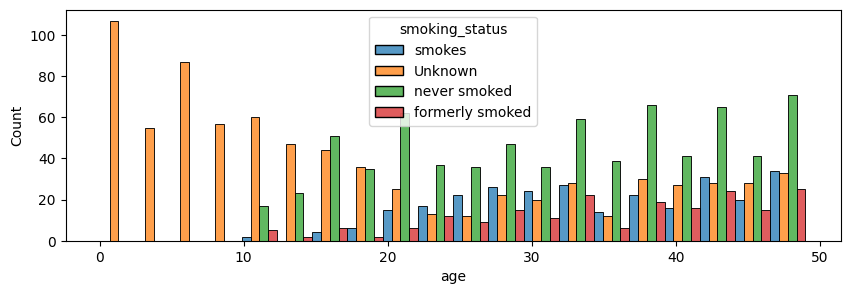

In [22]:
plt.figure(figsize=(10, 3))
sns.histplot(data=stroke_train, x='age', hue='smoking_status', multiple='dodge', bins=20, edgecolor='black')
plt.show();

Del gráfico podemos observar que los posibles valores del atributo smoking_status son: smokes, Unknow, never smoked o formerly smoked.

En la documentación de la [web](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) pone que el valor "Unknown" significa que la información no está disponible para este paciente, es decir que hemos de transformarlo en un valor Nan:

In [23]:
print(stroke_train['smoking_status'].value_counts())
stroke_train.loc[stroke_train['smoking_status'] == 'Unknown', 'smoking_status'] = np.nan

Unknown            771
never smoked       726
smokes             280
formerly smoked    195
Name: smoking_status, dtype: int64


Observamos también que los posibles valores de smoking_status siguen cierto orden: never_smoked, formerly_smoked y smokes; el grado de tendencia a fumar. Este orden puede ser significativo para nuestro problema, es por ello que lo codificamos de esta forma:

In [24]:
stroke_train['smoking_status'].replace(['never smoked', 'formerly smoked', 'smokes'], [0,1,2], inplace=True)
stroke_train.head()

,age,gender,hypertension,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
206,29.0,0,0,0,0,207.58,22.8,2.0,0,1,0,0
2037,2.0,1,0,0,0,105.75,19.8,NaN,0,0,0,1
1824,42.0,1,0,1,1,80.00,27.5,0.0,0,1,0,0
2029,39.0,1,0,1,0,78.24,28.6,NaN,0,1,0,0
2441,42.0,0,0,1,1,67.97,23.8,NaN,0,0,0,0


### Corrección de valores: Variables perdidas (missing values)

In [25]:
stroke_train.isna().sum()


age                          0
gender                       0
hypertension                 0
ever_married                 0
Residence_type               0
avg_glucose_level            0
bmi                          0
smoking_status             771
work_type_Never_worked       0
work_type_Private            0
work_type_Self-employed      0
work_type_children           0
dtype: int64

Podemos ver que las únicas variables perdidas son el "Unknow" de smoking_status.

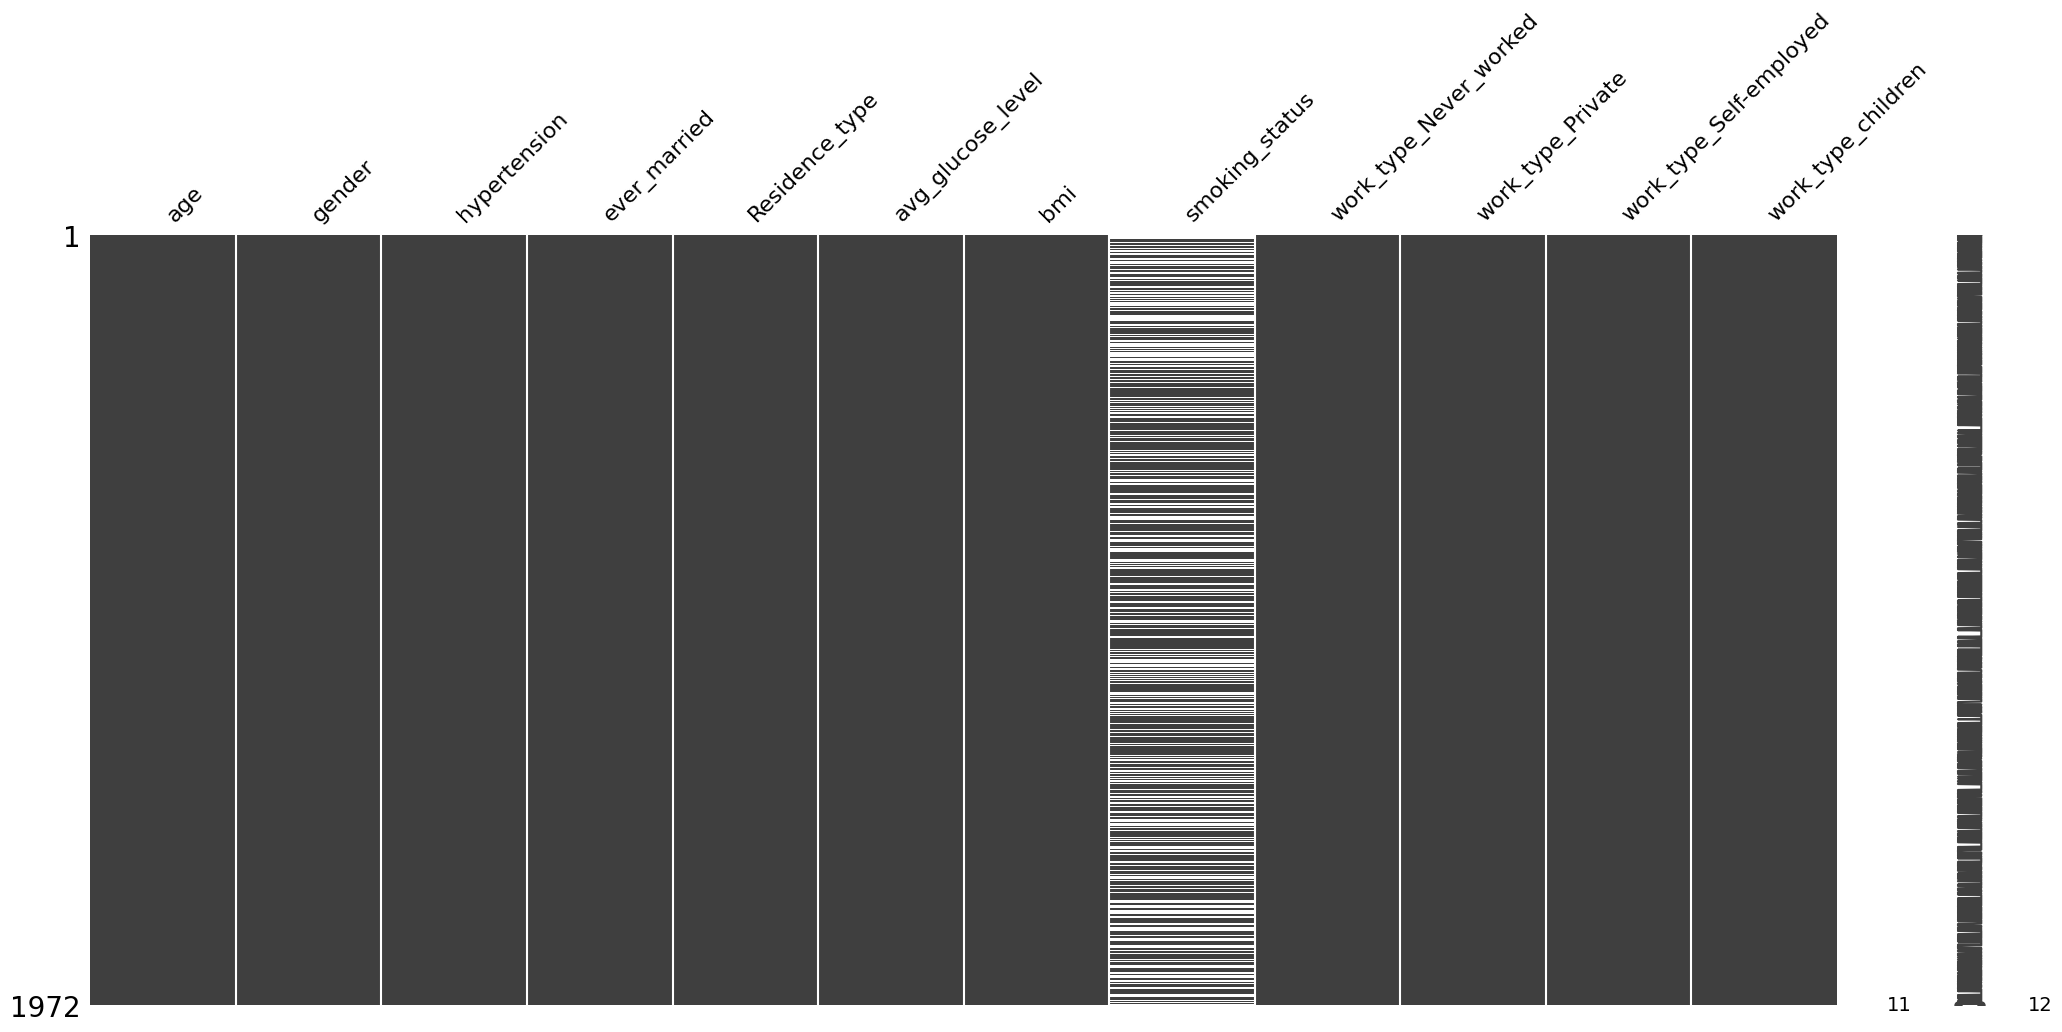

In [26]:
import missingno as msno
msno.matrix(stroke_train);

Podemos ver que la variable smoking_status tiene 771 valores perdidos.

Como es una cantidad elevada, no es una buena opción eliminar los ejemplos que tengan la variable perdida, porque perderíamos bastantes casos. Tampoco es una buena opción eliminar la variable, porque tiene una relación bastante directa con la edad, una persona joven no suele fumar mientras que una mayor sí. La idea es imputar smoking_status sin que distorsione mucho la distribución de la variable.

Intentamos imputar sus valores de la manera más neutra posible, no utilizamos la variable respuesta para la imputación, ya que segaríamos los datos. Es por ello que utilizamos el método de vecinos cercanos:

In [27]:
from sklearn.impute import KNNImputer

data = stroke_train.loc[:, stroke_train.columns != 'age'].values
knni_smoking = KNNImputer(n_neighbors=20)
i_smoking_status = knni_smoking.fit_transform(data)[:,6]

stroke_train['i_smoking_status'] = i_smoking_status
stroke_train['i_smoking_status'] = stroke_train['i_smoking_status'].astype(int)

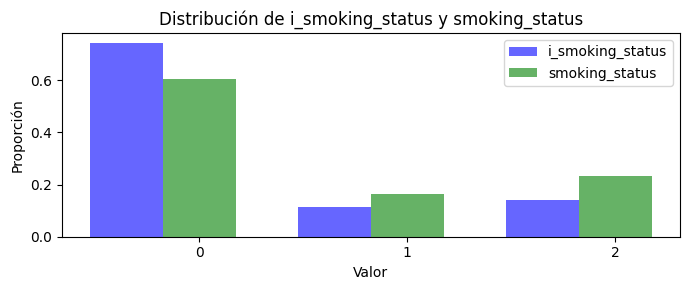

Media de i_smoking_status: 0.3975659229208925
Varianza de i_smoking_status: 0.7237047130105612


In [28]:
import matplotlib.pyplot as plt

# Calcular el conteo de cada valor para ambas columnas
i_smoking_status_counts = stroke_train['i_smoking_status'].value_counts(normalize=True).sort_index()
smoking_status_counts = stroke_train['smoking_status'].value_counts(normalize=True).sort_index()

# Establecer la posición de las barras en x
bar_width = 0.35
index = i_smoking_status_counts.index
r1 = range(len(index))
r2 = [i + bar_width for i in r1]

plt.figure(figsize=(7, 3))

# Crear las barras
plt.bar(r1, i_smoking_status_counts, width=bar_width, color='blue', alpha=0.6, label='i_smoking_status')
plt.bar(r2, smoking_status_counts, width=bar_width, color='green', alpha=0.6, label='smoking_status')

# Etiquetas, título y leyenda
plt.xlabel('Valor')
plt.ylabel('Proporción')
plt.title('Distribución de i_smoking_status y smoking_status')
plt.xticks([r + bar_width for r in range(len(i_smoking_status_counts))], index)
plt.legend()

plt.tight_layout()
plt.show();

print('Media de i_smoking_status:', stroke_train['i_smoking_status'].mean());
print('Varianza de i_smoking_status:', stroke_train['i_smoking_status'].std());


In [29]:
stroke_train.drop(columns=['smoking_status'], inplace=True)

### Corrección de valores: Valores extremos (outliers)

In [30]:
from sklearn.neighbors import LocalOutlierFactor

local_outlier_factor = LocalOutlierFactor(n_neighbors=20)
result = local_outlier_factor.fit_predict(stroke_train.values)

outliers = result == -1
no_outliers = result == 1

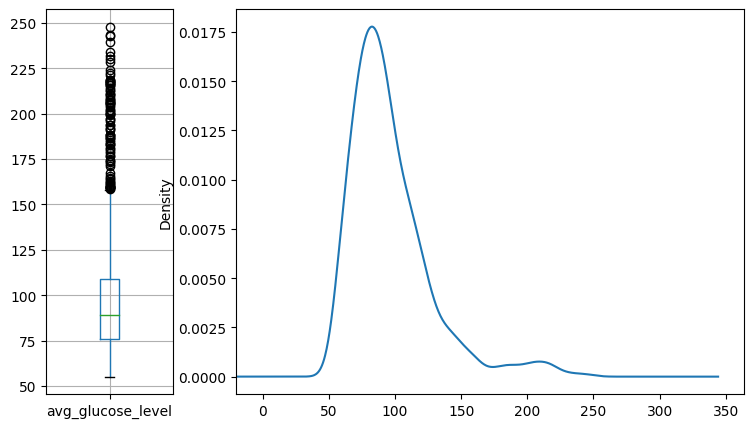

In [31]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
stroke_train[no_outliers].boxplot(column='avg_glucose_level',ax=axes[0]);
stroke_train[no_outliers]['avg_glucose_level'].plot.kde().set_xlim(left=-20);

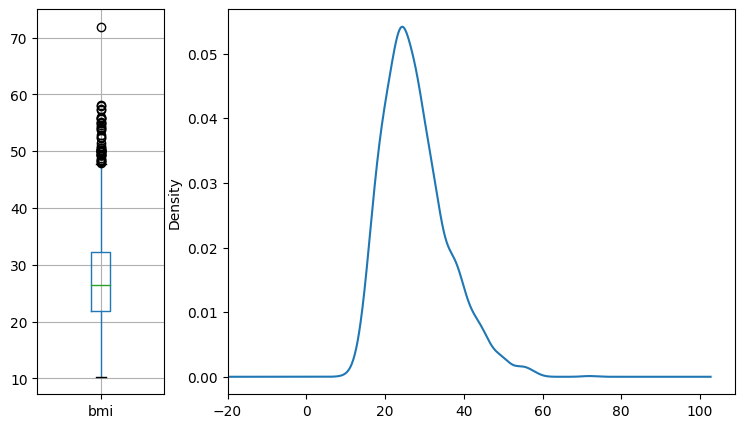

In [32]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
stroke_train[no_outliers].boxplot(column='bmi',ax=axes[0]);
stroke_train[no_outliers]['bmi'].plot.kde().set_xlim(left=-20);

## Preproceso del conjunto de test

Aplicamos el preproceso de datos al conjunto de test haciendo los mimos cambios que al conjunto de entrenamineto

In [33]:
stroke_test.drop(columns=['heart_disease', 'stroke'], inplace=True)
#stroke_test.drop(columns=['hypertension', 'heart_disease', 'stroke'], inplace=True)

# Convertimos la variable a categorica y la reescribimos con los codigos numericos que corresponden a cada categoria
stroke_test['gender'].replace(['Male','Female'], [0,1], inplace=True)
stroke_test['ever_married'].replace(['No','Yes'], [0,1], inplace=True)
stroke_test['Residence_type'].replace(['Urban', 'Rural'], [0,1], inplace=True)
stroke_test.loc[stroke_test['smoking_status'] == 'Unknown', 'smoking_status'] = np.nan
stroke_test['smoking_status'].replace(['never smoked', 'formerly smoked', 'smokes'], [0,1,2], inplace=True)

# Generamos c-1 variables, las añadimos al dataframe y eliminamos la variable
dummies = pd.get_dummies(stroke_test['work_type'], drop_first=True, prefix='work_type', prefix_sep='_')
stroke_test = pd.concat([stroke_test,dummies], axis=1)
stroke_test.drop(columns=['work_type'], inplace=True)
stroke_test.head()

,age,gender,hypertension,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
2714,38.0,0,0,1,1,73.76,37.4,0.0,0,1,0,0
333,23.0,1,0,0,0,79.39,27.6,0.0,0,1,0,0
70,23.0,1,0,0,0,99.92,25.8,0.0,0,1,0,0
569,23.0,1,0,0,1,90.84,31.6,0.0,0,1,0,0
118,12.0,1,0,0,1,75.22,20.9,NaN,0,0,0,1


In [34]:
stroke_test.isna().sum()

age                          0
gender                       0
hypertension                 0
ever_married                 0
Residence_type               0
avg_glucose_level            0
bmi                          0
smoking_status             336
work_type_Never_worked       0
work_type_Private            0
work_type_Self-employed      0
work_type_children           0
dtype: int64

In [35]:
from sklearn.impute import KNNImputer

data = stroke_test.loc[:, stroke_test.columns != 'age'].values
knni_smoking = KNNImputer(n_neighbors=20)
i_smoking_status = knni_smoking.fit_transform(data)[:,6]
#i_smoking_status = knni_smoking.fit_transform(data)[:,data.columns == 'smoking_status']

stroke_test['i_smoking_status'] = i_smoking_status
stroke_test['i_smoking_status'] = stroke_test['i_smoking_status'].astype(int)
stroke_test.drop(columns=['smoking_status'], inplace=True)

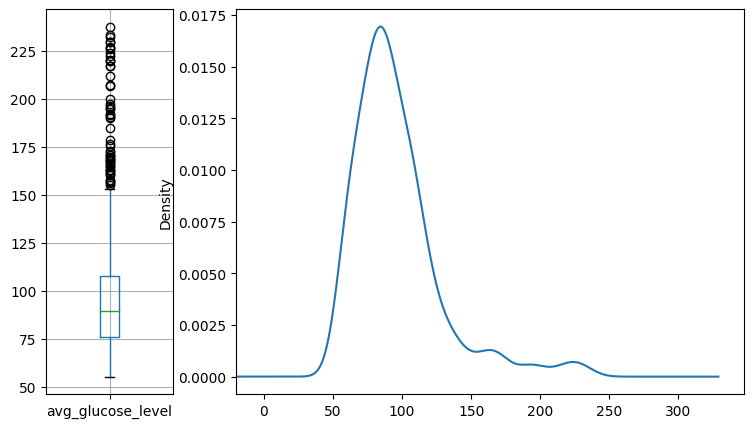

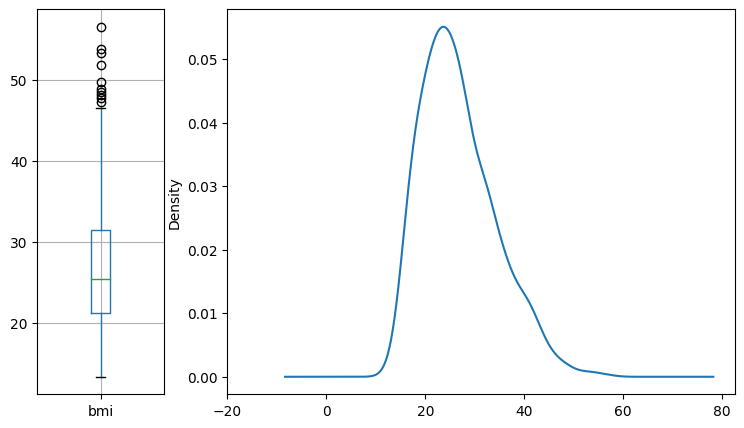

In [36]:
from sklearn.neighbors import LocalOutlierFactor

local_outlier_factor = LocalOutlierFactor(n_neighbors=20)
result = local_outlier_factor.fit_predict(stroke_test.values)

outliers = result == -1
no_outliers = result == 1

fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
stroke_test[no_outliers].boxplot(column='avg_glucose_level',ax=axes[0]);
stroke_test[no_outliers]['avg_glucose_level'].plot.kde().set_xlim(left=-20);

fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
stroke_test[no_outliers].boxplot(column='bmi',ax=axes[0]);
stroke_test[no_outliers]['bmi'].plot.kde().set_xlim(left=-20);

# Apartado B
En este apartado vamos a aplicar un Análisis de Componentes Principales (PCA) al conjunto de entrenamiento y los visualizaremos en 2D representando la variable objetivo.

Para poder visualizar mejor los datos vamos a usar PCA. Para ello, primero vamos a estandarizar los datos:

In [37]:
#estandarizacion (poner media a 0 y desviación estándar a 1)
from sklearn.preprocessing import StandardScaler

data_columns = [col for col in stroke_train.columns if col != 'age']

stroke_train_standarized = stroke_train.copy()
stroke_train_standarized[data_columns] = StandardScaler().fit_transform(stroke_train[data_columns])

stroke_test_standarized = stroke_test.copy()
stroke_test_standarized[data_columns] = StandardScaler().fit_transform(stroke_test[data_columns])

stroke_train_standarized.describe().T
stroke_test_standarized.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1972.0,2.715e+01,14.428,0.080,15.750,28.000,40.000,49.000
gender,1972.0,5.765e-17,1.000,-1.218,-1.218,0.821,0.821,0.821
hypertension,1972.0,3.873e-17,1.000,-0.173,-0.173,-0.173,-0.173,5.796
ever_married,1972.0,1.540e-16,1.000,-0.915,-0.915,-0.915,1.092,1.092
Residence_type,1972.0,-1.757e-16,1.000,-1.003,-1.003,0.997,0.997,0.997
avg_glucose_level,1972.0,4.648e-16,1.000,-1.301,-0.655,-0.228,0.388,5.051
bmi,1972.0,3.657e-16,1.000,-2.041,-0.704,-0.169,0.517,8.107
work_type_Never_worked,1972.0,-6.080e-17,1.000,-0.099,-0.099,-0.099,-0.099,10.139
work_type_Private,1972.0,-1.009e-16,1.000,-1.182,-1.182,0.846,0.846,0.846
work_type_Self-employed,1972.0,1.982e-17,1.000,-0.282,-0.282,-0.282,-0.282,3.550


,count,mean,std,min,25%,50%,75%,max
age,846.0,2.605e+01,14.411,0.240,14.000,27.000,39.000,49.000
gender,846.0,1.533e-16,1.001,-1.214,-1.214,0.824,0.824,0.824
hypertension,846.0,4.514e-17,1.001,-0.152,-0.152,-0.152,-0.152,6.597
ever_married,846.0,3.150e-17,1.001,-0.897,-0.897,-0.897,1.115,1.115
Residence_type,846.0,3.779e-17,1.001,-0.981,-0.981,-0.981,1.019,1.019
avg_glucose_level,846.0,8.399e-17,1.001,-1.252,-0.623,-0.215,0.341,5.230
bmi,846.0,-2.688e-16,1.001,-1.713,-0.723,-0.184,0.590,6.396
work_type_Never_worked,846.0,1.890e-17,1.001,-0.060,-0.060,-0.060,-0.060,16.763
work_type_Private,846.0,-1.680e-17,1.001,-1.159,-1.159,0.863,0.863,0.863
work_type_Self-employed,846.0,-6.719e-17,1.001,-0.276,-0.276,-0.276,-0.276,3.619


Separamos la variable objetivo del resto:

In [38]:
X_train = stroke_train_standarized.loc[:,stroke_train_standarized.columns != 'age']#[:,data_columns]
y_train = stroke_train_standarized['age']

X_test = stroke_test_standarized.loc[:,stroke_test_standarized.columns != 'age']
y_test = stroke_test_standarized['age']


In [39]:
stroke_train_standarized.to_csv('stroke_train_standarized.csv', index=False)
stroke_test_standarized.to_csv('stroke_test_standarized.csv', index=False)

Aplicamos el método PCA de scikit-learn:

In [40]:
from sklearn.decomposition import PCA

myPCA = PCA().fit(X_train);

print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[0.22583611 0.12444404 0.09668185 0.09411113 0.09125058 0.08999051
 0.08381367 0.07192535 0.05532796 0.0518117  0.01480708]
[0.22583611 0.35028015 0.446962   0.54107313 0.63232372 0.72231423
 0.8061279  0.87805326 0.93338122 0.98519292 1.        ]


En el primer vector se puede ver cuanta nueva varianza aporta cada uno de los distintos componentes. Mientras que el segundo aporta la varianza acumulada de los diferentes componentes. Se puede ver que con 7 componentes obtenemos un 80% de la varianza.

También se puede visualizar con esta gráfica:

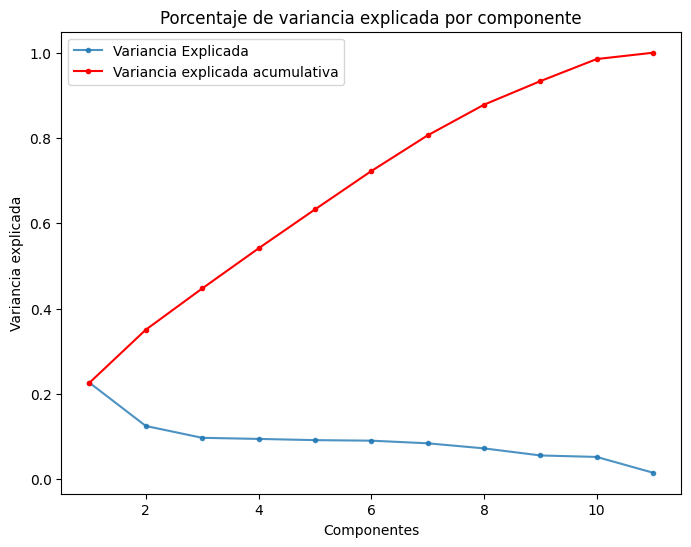

In [41]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

La línea roja representa la varianza acumulada, mientras que la azul la individual de cada componete.

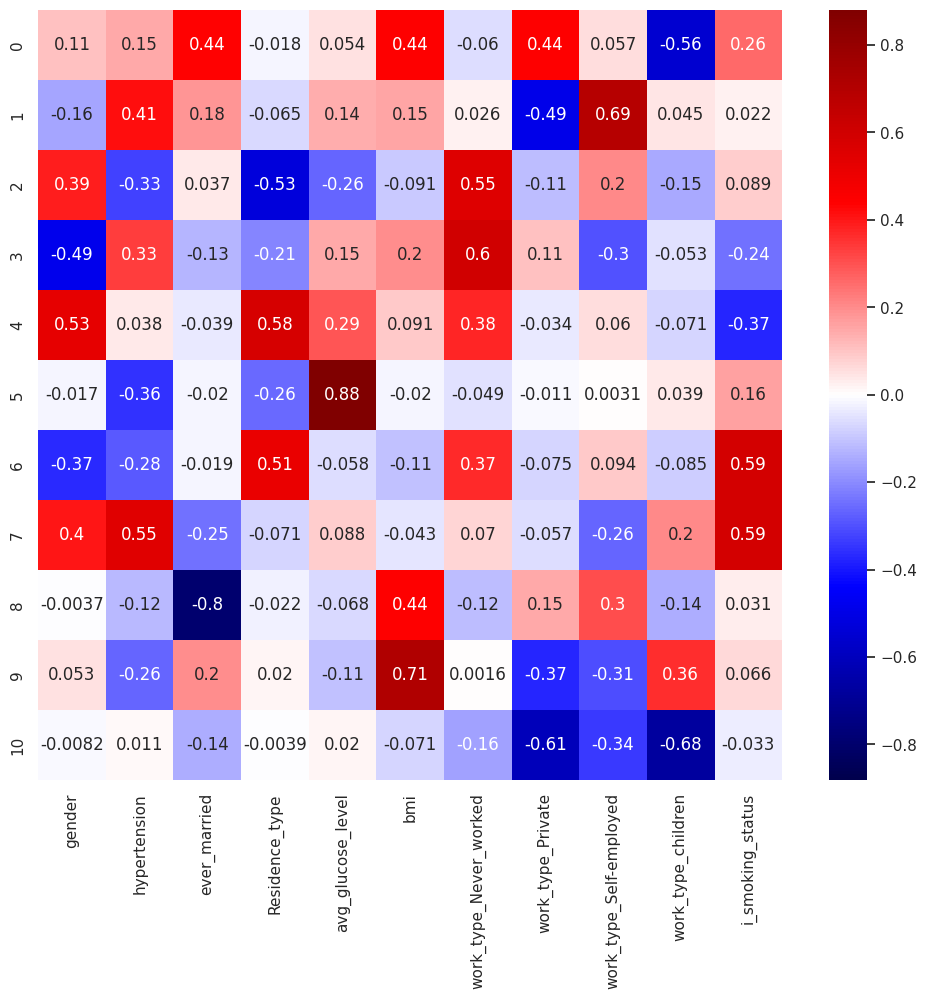

In [42]:
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(myPCA.components_, cmap='seismic',
            xticklabels=X_train.columns,
            vmin=-np.max(np.abs(myPCA.components_)),
            vmax=np.max(np.abs(myPCA.components_)),
            annot=True);

En el heatmap se puede ver las correlaciones de las diferentes atributos por componente.

Ahora vamos a transformar nuestro conjunto de datos utilizando el PCA entrenado, para visualizarlo vamos a coger 2 componentes:

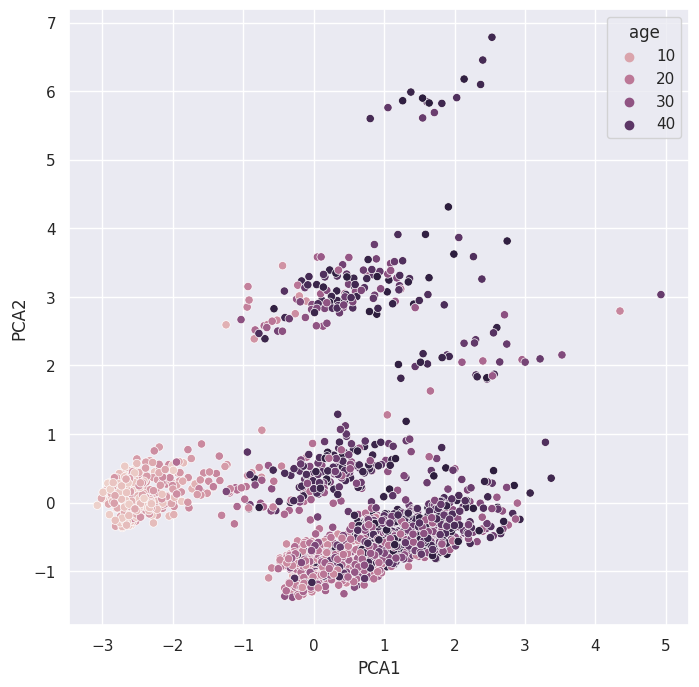

In [43]:
transformed_X_train = myPCA.transform(X_train)
plt.figure(figsize=(8,8));
sns.scatterplot(x=transformed_X_train[:,0], y=transformed_X_train[:,1], hue=y_train);
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show();

Con los resultados de la gráfica de 2 componentes podemos afirmar que existe una relación entre las variables del conjunto de datos con la variable objetivo, porque se puede observar una agrupación clara de las diferentes edades: la nueve de puntos inferior izquierda conforma el rango de los 10 años, a medida que nos desplazamos en el eje del PCA1 vamos aumentando la edad; de la misma manera cuando subimos en diagonal en el eje PCA2.

Aunque con 2 dimensiones ya se puede apreciar una diferenciación clara de los distintos rangos de edad. Con más dimensiones obtendríamos una representación todavía más clara y precisa. Con 7 componentes sobrepasaríamos el lindar del 80% de varianza acumulada como hemos visto en la gráfica de tendencias anteriormente.

# Apartado C
En este apartado vamos a ajustar el modelo de regresión LASSO para predecir la edad de las personas, y vamos a estimar la calidad de la regresión.

In [44]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from yellowbrick.regressor import AlphaSelection
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]

In [45]:
lasso_cv = LassoCV(alphas=lambdas,cv=5).fit(X_train,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 0.1 R2 score: 0.7617421632792604


Podemos ver como la mejor predicción la obtenemos con una lambda de 0.1 y con un valor R2 de aproximadamente 0.7617.

Veamos una visualización de como evoluciona el parámetro alpha:

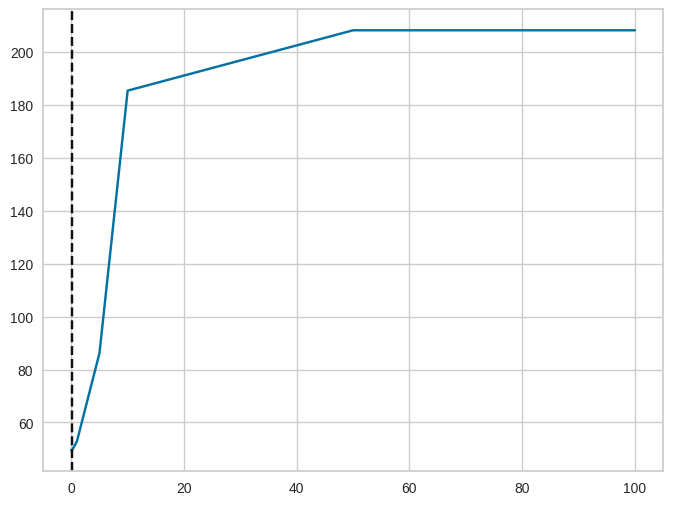

In [46]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(LassoCV(alphas=lambdas));
vis.fit(X_train, y_train);

In [47]:
r2_results = pd.DataFrame({'lasso_cv':lasso_r2},index=['CV R2'])

r2_results.loc['Train R2', :] =[r2_score(y_train,lasso_cv.predict(X_train))]
r2_results.loc['lambda','lasso_cv']=lasso_cv.alpha_
r2_results

,lasso_cv
CV R2,0.762
Train R2,0.765
lambda,0.100


Como hemos indicamos previamente, logramos un valor cercano a 0.765 para el conjunto de entrenamiento usando una lambda de 0.1. Consideramos un acierto de aproximadamente el 76.5% un resutlado decente.

En la siguiente tabla se presentan los pesos asignados a cada atributo de nuestro dataset. Observamos que 'ever_married' tiene la mayor influencia positiva con 6.014. Mientras que  'work_type_children' es el que más impacto negativo tienen con un valor de -7.793.

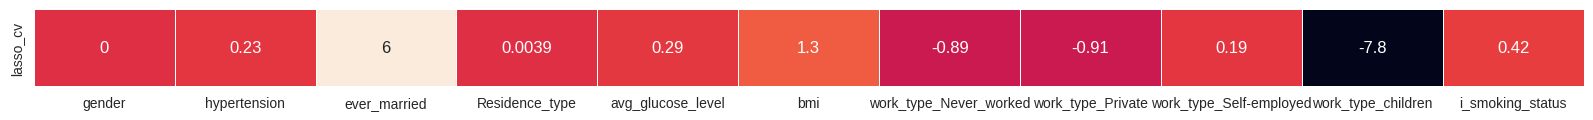

In [48]:
weights = pd.DataFrame({'lasso_cv':lasso_cv.coef_},index=X_train.columns)
plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['lasso_cv'],:],annot=True, linewidths=.5,cbar=False,xticklabels=True);

# Apartado D
En esta apartado vamos a representar los residuos de la regresión y los valores reales contra las predicciones para el conjunto de test.

In [49]:
train_prediction = lasso_cv.predict(X_train)
train_r2_laso = r2_score(y_train,lasso_cv.predict(X_train))
train_mae = mean_absolute_error(y_train,train_prediction)
train_mean_square_error = mean_squared_error(y_train, train_prediction)

test_prediction = lasso_cv.predict(X_test)
test_r2_laso = r2_score(y_test,lasso_cv.predict(X_test))
test_mae = mean_absolute_error(y_test,test_prediction)
test_mean_square_error = mean_squared_error(y_test, test_prediction)

df = pd.DataFrame(columns=["R2","mean absolute error","mean square error"], index=["Train", "Test"])
df["R2"] = [train_r2_laso, test_r2_laso]
df["mean absolute error"] = [train_mae, test_mae]
df["mean square error"] = [train_mean_square_error, test_mean_square_error]
df

,R2,mean absolute error,mean square error
Train,0.765,5.692,48.959
Test,0.780,5.446,45.570



Con el conjunto de test obtenemos unas predicciones ligeramente mejores que con las de entrenamiento, un 0.780. El mean square error, el cuadrado de la discrepancia entre los valores reales y los predichos, es del 45.570, y el mean absolute error, la diferencia promedio entre los valores reales y los estimados, es de alrededor de 5.496. Podemos decir así que el margen de error no es tampoco tan elevado.


En la siguiente gráfica podemos ver la comparación entre los valores reales y los estimados por nuestro modelo. Se observan diferentes agrupaciones o zonas, que se asocian a los variados rangos de edad de nuestro dataset.

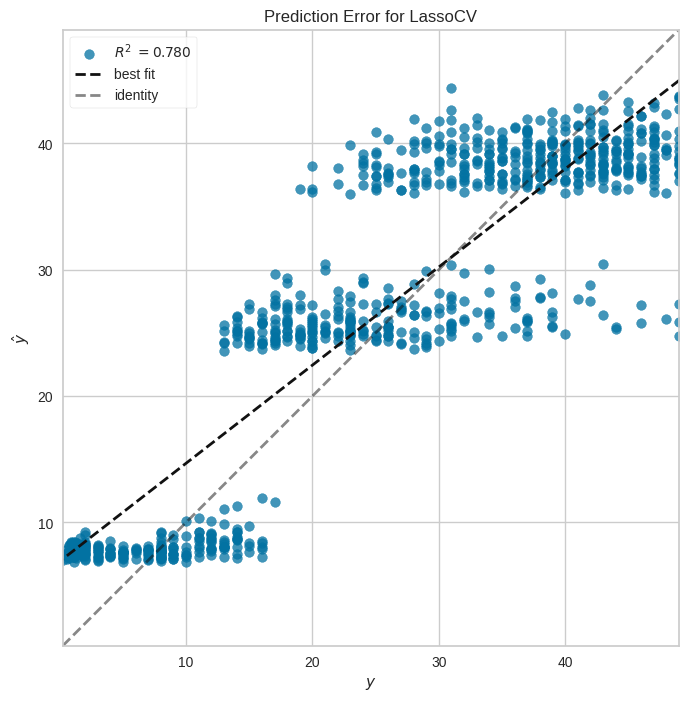

In [50]:
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8));
visualizer = prediction_error(lasso_cv, X_test, y_test, is_fitted=True);

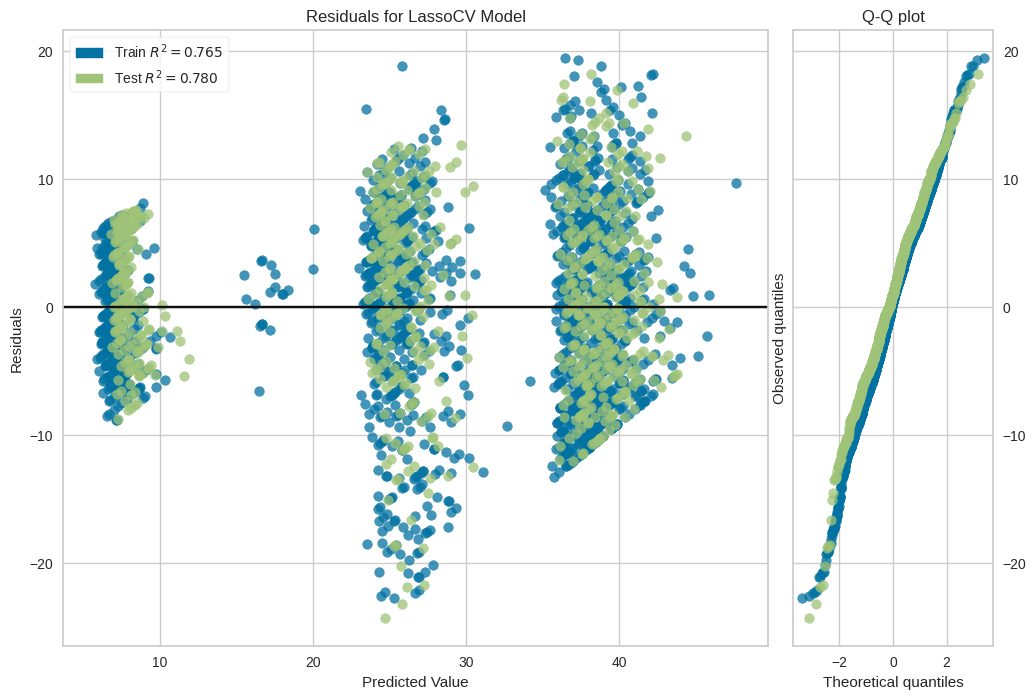

In [51]:
from yellowbrick.regressor import residuals_plot

plt.figure(figsize=(12,8));
viz = residuals_plot(lasso_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

Con esta última gráfica podemos ver la discrepancia entre el valor real de la variable que queremos predecir y el valor estimado. Se distinguen claramente 3 agrupaciones, lo que sugiere que nuestro modelo tiende a generalizar por rangos de edades en lugar de individualizar cada año. Es notable que los residuos son menores en la población joven, quizás debido a características más definitorias en ese grupo, como por la variable work_type_children y el no estar casados. Sin embargo, para el grupo de 20 a 30 años, los residuos tienden a ser más altos debido a la diversidad de situaciones de vida en esa etapa: diferentes tipos de trabajo, pueden estar casados o no, el nivel de fumar, etc. Al igual que con el grupo joven, los individuos mayores se clasifican con mayor facilidad, probablemente debido a la menor variedad en sus circunstancias de vida.